In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
df_ori = pd.read_csv('Dataset 2.csv', parse_dates=[0])
df_ori = df_ori.set_index('Date')
df_predictors = df_ori.drop(['PCI'], axis = 1)

In [3]:
df_ori.iloc[:,10:].tail(6)

,NM,FBM,MCF,MSW,EMP,MIER,PCI
Date,,,,,,,
2019-03-31,1278293.0,1678.0,1739.0,21978.0,45055.0,86.0,198858.0
2019-06-30,1291613.0,1655.0,1742.0,21787.0,45347.0,93.0,203386.0
2019-09-30,1290416.0,1610.0,1696.0,22013.0,45596.0,84.0,218143.0
2019-12-31,1326405.0,1592.0,1691.0,22427.0,45867.0,82.0,214678.0
2020-03-31,1355344.0,1455.0,1539.0,22728.0,45895.0,51.0,212257.0
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def predict_predictors(df_predictors, column_no, lag):
    predictor = df_predictors.columns[column_no]
    df_predictors = df_ori.copy().drop(['PCI'], axis =1)
    df_predictor = df_predictors[predictor]
    df_ok = pd.DataFrame()
    
    for j in range(1, lag):
        df_ok['%s' %df_predictor.name + '(t-%s)' %j] = df_predictor.shift(j).T
    
    df_ok = df_ok.dropna()
    df_ok[predictor] = df_ori[df_ori.index >= df_ok.index[0]][[predictor]]
    
    X = df_ok.iloc[:-1,:-1].values
    y = df_ok.iloc[:-1,-1].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import make_regression

    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(X_train, y_train)
    
    prediction = []
    prediction.extend(regr.predict(X_train))
    prediction.extend(regr.predict(X_test))
    
    df_ok = df_ok.reset_index()
    df_ok['Prediction'] = pd.DataFrame(prediction)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(df_ok[df_ok.columns[-2]][:-1], df_ok['Prediction'][:-1], squared=False)
    #print('RMSE is', rmse, '\n')
    df_ok['Prediction'][-1:] = regr.predict(df_ok[df_ok.columns[1:lag]][-1:].values)
    
    #if df_ok[predictor][-1:].isna().values == True:
    #    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values
    
    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values    
    df_ok = df_ok.drop('Prediction', axis = 1)
    df_ok = df_ok.set_index('Date')

    return rmse

In [5]:
rows = []
for i in tqdm(range(len(df_ori.columns) -1)):
    for j in range(2, 13):
        rmse = predict_predictors(df_predictors, column_no = i, lag = j)
        row = list([df_predictors.columns[i], j, rmse])
        rows.append(row)
        
df_rmse = pd.DataFrame(rows, columns = ['Attribute', 'Lag', 'RMSE'])
least_rmse_df = df_rmse.groupby(['Attribute']).RMSE.agg('min')

rows = []
for i in range(len(least_rmse_df)):
    for j in range(len(df_rmse)):
        if df_rmse['RMSE'][j] == least_rmse_df[i]:
            row = df_rmse.iloc[j,:].tolist()
            rows.append(row)
            
df_least_rmse = pd.DataFrame(rows, columns = ['Attribute', 'Lag', 'RMSE']) 
df_least_rmse

100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


,Attribute,Lag,RMSE
0,CC,11,34584.439122
1,CCD,12,2198.020851
2,CCS,11,2866.868020
3,EMP,11,722.451067
4,FBM,3,93.362967
5,FS,11,1069.646062
6,ICG,12,854.581484
7,LDH,12,2653.412135
8,LOWT,11,2688.578702
9,MCF,4,105.304199


In [6]:
def predict_predictors(df_predictors, column_no, lag):
    predictor = df_predictors.columns[column_no]
    df_predictors = df_ori.copy().drop(['PCI'], axis =1)
    df_predictor = df_predictors[predictor]
    df_ok = pd.DataFrame()
    
    for j in range(1, lag):
        df_ok['%s' %df_predictor.name + '(t-%s)' %j] = df_predictor.shift(j).T
    
    df_ok = df_ok.dropna()
    df_ok[predictor] = df_ori[df_ori.index >= df_ok.index[0]][[predictor]]
    
    X = df_ok.iloc[:-1,:-1].values
    y = df_ok.iloc[:-1,-1].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import make_regression

    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(X_train, y_train)
    
    prediction = []
    prediction.extend(regr.predict(X_train))
    prediction.extend(regr.predict(X_test))
    
    df_ok = df_ok.reset_index()
    df_ok['Prediction'] = pd.DataFrame(prediction)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(df_ok[df_ok.columns[-2]][:-1], df_ok['Prediction'][:-1], squared=False)
    #print('RMSE is', rmse, '\n')
    df_ok['Prediction'][-1:] = regr.predict(df_ok[df_ok.columns[1:lag]][-1:].values)
    
    #if df_ok[predictor][-1:].isna().values == True:
    #    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values
    
    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values    
    df_ok = df_ok.drop('Prediction', axis = 1)
    df_ok = df_ok.set_index('Date')

    return df_ok[df_ok.columns[-1]]

In [7]:
df_predictors_cleaned = pd.DataFrame()
df_predictors_cleaned['Date'] = df_predictors.index
df_predictors_cleaned = df_predictors_cleaned.set_index('Date')
for i in tqdm(range(len(df_least_rmse))):
    for j in range(len(df_predictors.columns)):
        if df_predictors.columns[j] == df_least_rmse['Attribute'][i]:
            predictor = predict_predictors(df_predictors, column_no = j, lag = df_least_rmse['Lag'][i])
            df_predictors_cleaned["%s" %df_predictors.columns[j]] = predictor

100%|██████████| 16/16 [00:02<00:00,  5.83it/s]


In [8]:
df_predictors_predicted = df_predictors_cleaned[-1:]
df_predictors_predicted

,CC,CCD,CCS,EMP,FBM,FS,ICG,LDH,LOWT,MCF,MIER,MSW,NM,SOM,SOPC,TSP
Date,,,,,,,,,,,,,,,,
2020-06-30,881633.439833,55988.553333,117818.193,45438.133833,1516.889524,19008.067333,18086.605167,84040.4715,56395.464667,1652.869048,75.242167,21880.103,1287626.498,127951.8605,135064.252226,2740.224833


In [9]:
for i in range(len(df_predictors.columns)):
    for j in range(len(df_predictors_predicted.columns)):
        if df_predictors.columns[i] == df_predictors_predicted.columns[j]:
            df_predictors[df_predictors.columns[i]][-1:] =  int(df_predictors_predicted[df_predictors_predicted.columns[j]][-1:].values)

In [11]:
df_rf = pd.merge(df_predictors, df_ori['PCI'], how='left', left_on='Date', right_on='Date')

In [13]:
df_rf.to_csv('Random Forest Dataset.csv')

In [12]:
def select_attributes(data, label, top_attribute):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k=5)
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    
    # creating columns names for the selected features
    data = df_rf.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(ranked_features['Predictors'].tolist()[:top_attribute])
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return data

In [15]:
attribute_rmse = []
for i in tqdm(range(1,len(df_rf))):
    from sklearn.model_selection import train_test_split
    df_top_rf = select_attributes(df_rf, label='PCI', top_attribute=i)
    X_train = df_top_rf.iloc[:-1, :-1].values
    y_train = df_top_rf.iloc[:-1, -1:].values
    X_test  = df_top_rf.iloc[-1:, :-1].values
    y_test  = df_top_rf.iloc[-1:, -1:].values
    
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=3, random_state=0)
    regr.fit(X_train, y_train)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_train, regr.predict(X_train), squared=False) 
    predictor = df_top_rf.columns[:-1].values
    attribute_rmse.append([i, rmse, predictor])

100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


In [17]:
df_optimise_attribute = pd.DataFrame(attribute_rmse, columns = ['No of Top Attributes', 'RMSE', 'Attributes'])
df_optimise_attribute

,No of Top Attributes,RMSE,Attributes
0,1,2497.087664,[EMP]
1,2,2814.114051,"[EMP, MSW]"
2,3,2919.033620,"[EMP, MSW, FS]"
3,4,3020.452656,"[EMP, MSW, FS, CCS]"
4,5,3056.153783,"[EMP, MSW, FS, CCS, NM]"
5,6,2881.178377,"[EMP, MSW, FS, CCS, NM, CC]"
6,7,2894.692685,"[EMP, MSW, FS, CCS, NM, CC, CCD]"
7,8,2795.759099,"[EMP, MSW, FS, CCS, NM, CC, CCD, SOM]"
8,9,2820.678000,"[EMP, MSW, FS, CCS, NM, CC, CCD, SOM, LOWT]"
9,10,2806.440579,"[EMP, MSW, FS, CCS, NM, CC, CCD, SOM, LOWT, LDH]"


Text(0.5, 1.0, '\nRMSE of Feature Selection\n')

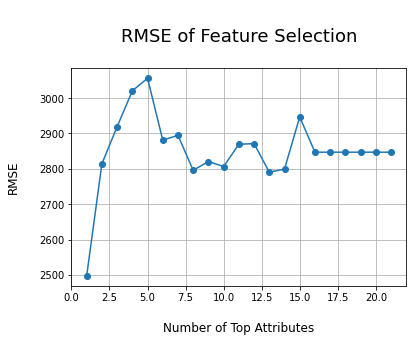

In [18]:
plt.plot(df_optimise_attribute['No of Top Attributes'], df_optimise_attribute['RMSE'], marker = 'o')
plt.grid()
plt.xlabel('\nNumber of Top Attributes\n',fontsize=12)
plt.ylabel('RMSE\n',fontsize=12)
plt.title('\nRMSE of Feature Selection\n',fontsize=18)

In [19]:
df_top_rf = select_attributes(df_rf, label='PCI', top_attribute=13)

In [20]:
X_train = df_top_rf.iloc[:-1, :-1].values
y_train = df_top_rf.iloc[:-1, -1:].values
X_test  = df_top_rf.iloc[-1:, :-1].values
y_test  = df_top_rf.iloc[-1:, -1:].values

In [21]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_train, regr.predict(X_train), squared=False) 
# rmse = mean_squared_error(y_valid, regr.predict(X_valid), squared=False) 

In [22]:
predict = regr.predict(X_test)
actual  = y_test

print("Random Forest predicted PCI for Quarter 2 2020 is RM", int(predict),  "million with RMSE of", int(rmse))

Random Forest predicted PCI for Quarter 2 2020 is RM 206955 million with RMSE of 2790


In [23]:
predictions = []
prediction_train = regr.predict(X_train).astype(int).tolist()
# prediction_valid = regr.predict(X_valid).astype(int).tolist()
prediction_test = regr.predict(X_test).astype(int).tolist()

# prediction_valid.extend(prediction_test)
# prediction_train.extend(prediction_valid)
# predictions.extend(prediction_train)

prediction_train.extend(prediction_test)
predictions.extend(prediction_train)

df_rf['Predictions'] = pd.DataFrame(predictions, index=df_rf.index)
df_rf.tail(6)

,FS,ICG,TSP,SOM,SOPC,CC,CCD,LOWT,CCS,LDH,NM,FBM,MCF,MSW,EMP,MIER,PCI,Predictions
Date,,,,,,,,,,,,,,,,,,
2019-03-31,18652.0,16967.0,2278.0,132716.0,131090.0,880615.0,54356.0,57092.0,117975.0,85736.0,1278293.0,1678.0,1739.0,21978.0,45055.0,86.0,198858.0,202218
2019-06-30,19155.0,18838.0,2502.0,124764.0,139709.0,880203.0,55384.0,55485.0,117321.0,84444.0,1291613.0,1655.0,1742.0,21787.0,45347.0,93.0,203386.0,203550
2019-09-30,19039.0,18504.0,2552.0,142484.0,133257.0,883634.0,57770.0,56455.0,118454.0,85972.0,1290416.0,1610.0,1696.0,22013.0,45596.0,84.0,218143.0,212563
2019-12-31,19217.0,19704.0,2603.0,146849.0,146059.0,888813.0,60814.0,57500.0,121170.0,89857.0,1326405.0,1592.0,1691.0,22427.0,45867.0,82.0,214678.0,212543
2020-03-31,19148.0,17778.0,2822.0,125747.0,96089.0,886922.0,53459.0,55107.0,119550.0,82294.0,1355344.0,1455.0,1539.0,22728.0,45895.0,51.0,212257.0,211914
2020-06-30,19008.0,18086.0,2740.0,127951.0,135064.0,881633.0,55988.0,56395.0,117818.0,84040.0,1287626.0,1516.0,1652.0,21880.0,45438.0,75.0,NaN,206955


In [24]:
df_rf = df_rf.reset_index()

Text(2020-07-15 00:00:00, 155000, 'Testing')

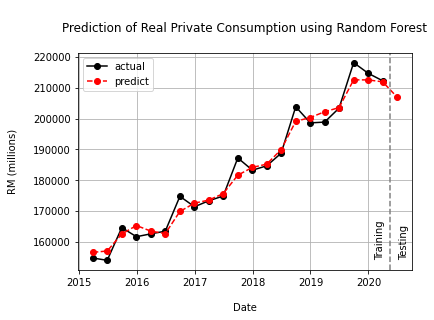

In [25]:
import datetime as dt


plt.plot_date(df_rf['Date'], df_rf['PCI'], color = 'black', marker = 'o', label = 'actual', linestyle = '-')
plt.plot_date(df_rf['Date'], df_rf['Predictions'], color = 'red', marker = 'o', label = 'predict', linestyle = '--')
plt.legend()
plt.grid()
plt.xlabel('\nDate')
plt.ylabel('RM (millions)\n')
plt.title('\nPrediction of Real Private Consumption using Random Forest\n')
# plt.axvline(dt.datetime(2018, 12, 31), linestyle= '--', color = 'grey')
plt.axvline(dt.datetime(2020, 5, 15), linestyle= '--', color = 'grey')
# plt.annotate('Training', xy=(dt.datetime(2018, 10, 15), 155000), rotation = 90)
plt.annotate('Training', xy=(dt.datetime(2020, 2, 15), 155000), rotation = 90)
plt.annotate('Testing', xy=(dt.datetime(2020, 7, 15), 155000), rotation = 90)